## Notebook 4 - Evaluating our GOES cloud thresholding

To test how well the thresholding is working from GOES radiances/brightnesses, let's pull the pixel for Kettle Ponds and compare to observed radiative fluxes for the SAIL/SPLASH/SoS site.

In [1]:
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

#### Load in in situ obs and processed GOES RGB composite

In [2]:
date = '20230605'

# In situ obs load
obs_path = '/storage/cdalden/goes/surface_obs/'
obs_file = f'isfs_sos_qc_geo_tiltcor_5min_v2_{date}.nc'

obs = xr.open_dataset(obs_path + obs_file)

# GOES data load
goes_path = '/storage/cdalden/goes/goes16/rgb_composite/'
goes_file = f'goes16_C02_C05_C13_RGB_colorado_{date}.nc'

# Use f-string to dynamically name the dataset
goes_ds_name = f'goes_{date}'
globals()[goes_ds_name] = xr.open_dataset(goes_path + goes_file)

# Access the dataset
goes_20230605


<xarray.Dataset> Size: 9GB
Dimensions:    (t: 288, y: 640, x: 966)
Coordinates:
  * t          (t) datetime64[ns] 2kB 2023-06-05T00:02:36.606086016 ... 2023-...
    x_image    float32 4B ...
    y_image    float32 4B ...
  * y          (y) float64 5kB 41.53 41.52 41.51 41.51 ... 37.02 37.01 37.01
  * x          (x) float64 8kB -112.1 -112.1 -112.1 ... -104.0 -104.0 -104.0
Data variables:
    refl_C02   (t, y, x) float64 1GB ...
    refl_C05   (t, y, x) float64 1GB ...
    btemp_C13  (t, y, x) float64 1GB ...
    green      (t, y, x) float64 1GB ...
    blue       (t, y, x) float64 1GB ...
    red        (t, y, x) float64 1GB ...

In [3]:
from netCDF4 import Dataset
try:
    ds = Dataset('/storage/cdalden/goes/surface_obs/sos_ds_5min_storage_with_tsurf.nc', 'r')
    print("File opened successfully.")
except Exception as e:
    print(f"Error: {e}")

Error: [Errno -101] NetCDF: HDF error: '/storage/cdalden/goes/surface_obs/sos_ds_5min_storage_with_tsurf.nc'


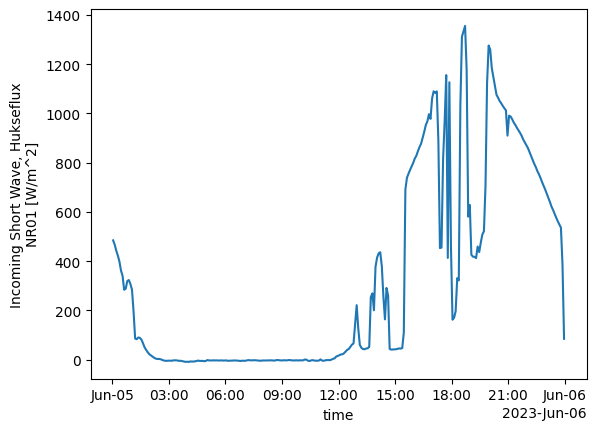

In [4]:
obs['Rsw_in_uw'].plot()

In [5]:
latitude = obs.latitude_uw.values
longitude = obs.longitude_uw.values
goes_crested_butte_pixel = globals()[goes_ds_name].sel(y=latitude, x=longitude, method='nearest')


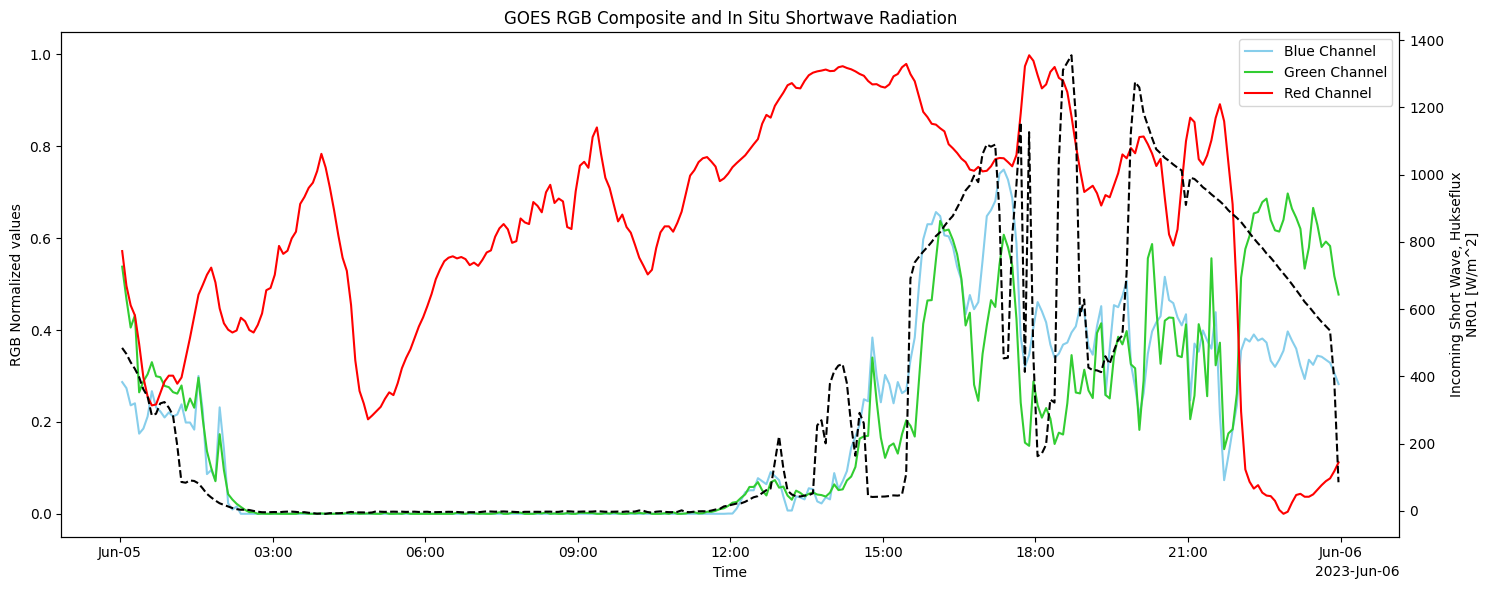

In [17]:
# Plot the GOES data for the specific pixel
fig, ax = plt.subplots(figsize=(15, 6))
goes_crested_butte_pixel['blue'].plot(ax=ax, label='Blue Channel', color='skyblue')
goes_crested_butte_pixel['green'].plot(ax=ax, label='Green Channel', color='limegreen')
goes_crested_butte_pixel['red'].plot(ax=ax, label='Red Channel', color='red')

ax2 = ax.twinx()
obs['Rsw_in_uw'].plot(ax=ax2, 
                             color='black', label='In Situ Shortwave In', ls = '--')


ax.set_xlabel('Time')
ax.set_ylabel('RGB Normalized values')
ax.set_title('GOES RGB Composite and In Situ Shortwave Radiation')
ax.legend()

plt.tight_layout()
plt.savefig(f'./plots/goes_rgb_kettle_ponds_comparison_{date}.png', dpi=300)

## Random Forest to determine thresholds

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

In [14]:
print(goes_crested_butte_pixel['t'])  # Time coordinates of the features dataset
print(obs['time'])

y_aligned = obs.reindex(time=goes_crested_butte_pixel['t'], method='nearest')

<xarray.DataArray 't' (t: 288)> Size: 2kB
array(['2023-06-05T00:02:36.606086016', '2023-06-05T00:07:36.497206016',
       '2023-06-05T00:12:36.496871040', ..., '2023-06-05T23:47:36.616214016',
       '2023-06-05T23:52:36.607197056', '2023-06-05T23:57:36.607851008'],
      shape=(288,), dtype='datetime64[ns]')
Coordinates:
  * t        (t) datetime64[ns] 2kB 2023-06-05T00:02:36.606086016 ... 2023-06...
    x_image  float32 4B ...
    y_image  float32 4B ...
    y        float64 8B 38.94
    x        float64 8B -107.0
Attributes:
    long_name:      J2000 epoch mid-point between the start and end image sca...
    standard_name:  time
    axis:           T
    bounds:         time_bounds
<xarray.DataArray 'time' (time: 288)> Size: 2kB
array(['2023-06-05T00:02:30.000000000', '2023-06-05T00:07:30.000000000',
       '2023-06-05T00:12:30.000000000', ..., '2023-06-05T23:47:30.000000000',
       '2023-06-05T23:52:30.000000000', '2023-06-05T23:57:30.000000000'],
      shape=(288,), dtype='dateti

ValueError: Indexer has dimensions ('t',) that are different from that to be indexed along 'time'

In [10]:
# Features and target
X = goes_crested_butte_pixel[['red', 'green', 'blue']]
y = obs['Rsw_in_uw']
X, y = xr.align(goes_crested_butte_pixel[['red', 'green', 'blue']], obs['Rsw_in_uw'], join='inner')
print(X)
print(y)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# Predict on test set
y_pred = rf.predict(X_test)

# Evaluate
print(classification_report(y_test, y_pred))

<xarray.Dataset> Size: 9kB
Dimensions:  (t: 288)
Coordinates:
  * t        (t) datetime64[ns] 2kB 2023-06-05T00:02:36.606086016 ... 2023-06...
    x_image  float32 4B ...
    y_image  float32 4B ...
    y        float64 8B 38.94
    x        float64 8B -107.0
Data variables:
    red      (t) float64 2kB ...
    green    (t) float64 2kB ...
    blue     (t) float64 2kB ...
<xarray.DataArray 'Rsw_in_uw' (time: 288)> Size: 1kB
[288 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 2kB 2023-06-05T00:02:30 ... 2023-06-05T23:...
Attributes:
    long_name:   Incoming Short Wave, Hukseflux NR01
    short_name:  Rsw.in.uw
    units:       W/m^2


ValueError: Found input variables with inconsistent numbers of samples: [3, 288]